In [1]:
import json
import os
from openai import OpenAI
from tqdm import tqdm

In [ ]:
api_key = ''
client = OpenAI(api_key=api_key)

In [3]:
file = 'samples.jsonl'
tags_file = 'tags.txt'
answers_file = 'answers.txt'

if not os.path.exists('responses.txt'):
    with open('responses.txt', 'w') as f:
        pass
else:
    os.remove('gpt-responses.txt')
    with open('gpt-responses.txt', 'w') as f:
        pass

In [4]:
samples = []
with open(file, 'r') as f:
    for line in f:
        sample = json.loads(line)
        samples.append({'patch': sample['patch'], 'msg': sample['msg']})

tags = []
with open(tags_file, 'r') as f:
    for line in f:
        tags.append(line.strip())

answers = []
with open(answers_file, 'r') as f:
    for line in f:
        answers.append(line.strip())

In [ ]:
res = []
for sample in tqdm(samples):
    #prompt = f"""Given the following git patch and commit message, do you consider this a good sample for training a code review generation model that recieves the diff as input and should predict the message or do you think this would present some kind of nosie that would be detrimental to the model's performance? Answer with a simple Yes or No."""
    
    prompt = "Given the following code diff and its associated review comment, is this instance valid and useful for training a review comment generation model that takes the diff as input and predicts the message, without introducing misleading noise?. Answer with only “Yes” or “No”."
    prompt += f"\n\nPatch:\n{sample['patch']}"
    prompt += f"\n\nCommit Message:\n{sample['msg']}"

    response = client.responses.create(
        model="gpt-5",
        instructions="Only answer with Yes or No",
        input=prompt
    )

    answer = response.output_text.strip()
    if answer not in ['Yes', 'No']:
        answer = 'Invalid Response'
    
    res.append(answer)
        
    with open('gpt-responses.txt', 'a') as f:
        f.write(answer + '\n')

100%|██████████| 383/383 [1:46:05<00:00, 16.62s/it]  


In [12]:
with open('gpt-responses.txt', 'r') as f:
    res = [line.strip() for line in f]

correct = 0
false_negatives = 0
false_positives = 0
tags_metrics = {
    'Unsure': {'Agree': 0, 'Disagree': 0},
    'Unclear': {'Agree': 0, 'Disagree': 0},
    'Inquiry': {'Agree': 0, 'Disagree': 0},
    'Comment': {'Agree': 0, 'Disagree': 0},
    'Chit-Chat': {'Agree': 0, 'Disagree': 0},
    'Remark': {'Agree': 0, 'Disagree': 0},
    'Context dependent': {'Agree': 0, 'Disagree': 0},
    'Another change': {'Agree': 0, 'Disagree': 0},
    'Other Line': {'Agree': 0, 'Disagree': 0},
    'Previous Comment': {'Agree': 0, 'Disagree': 0},
    'Broken_URL': {'Agree': 0, 'Disagree': 0}
}
no_counter = 0
total = len(samples)
for i in range(total):
    if res[i] == answers[i]:
        correct += 1
    elif answers[i] == 'Yes':
        false_negatives += 1
    elif answers[i] == 'No':
        false_positives += 1
    
    if answers[i] == 'No':
        tag_aux = tags[no_counter]
        if tag_aux not in tags_metrics:
            tags_metrics[tag_aux] = {'Agree': 0, 'Disagree': 0}
        if res[i] == 'No':
            tags_metrics[tag_aux]['Agree'] += 1
        else:
            tags_metrics[tag_aux]['Disagree'] += 1
        no_counter += 1

print(f"Total Samples: {total}")
print(f"Correct Responses: {correct}")
print(f"Accuracy: {correct/total*100:.2f}%")
print(f"False Negatives: {false_negatives}")
print(f"False Positives: {false_positives}")


Total Samples: 383
Correct Responses: 250
Accuracy: 65.27%
False Negatives: 55
False Positives: 78


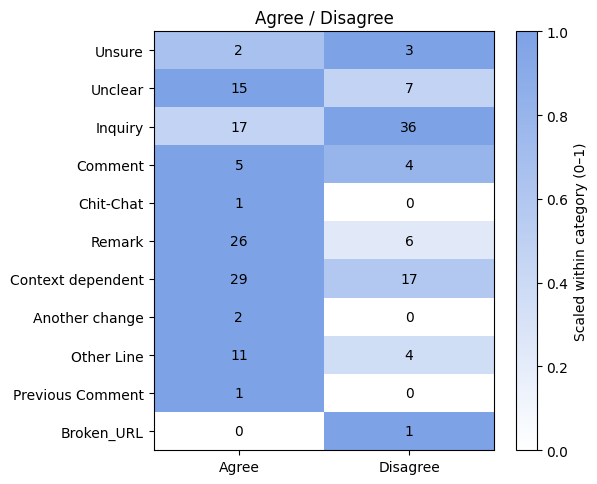

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = pd.DataFrame.from_dict(tags_metrics, orient="index")[["Agree", "Disagree"]].astype(float)

# Normalize each row independently (unique scale per category)
row_max = df.max(axis=1).replace(0, np.nan)
df_scaled = df.div(row_max, axis=0).fillna(0)

fig, ax = plt.subplots(figsize=(6, max(2.5, 0.45 * len(df))))
#im = ax.imshow(df_scaled.to_numpy(), aspect="auto", vmin=0, vmax=1)
blue_white = LinearSegmentedColormap.from_list("blue_white", ["white", "#7ea2e6"])

im = ax.imshow(df_scaled.to_numpy(), aspect="auto", vmin=0, vmax=1, cmap=blue_white)

ax.set_xticks(range(df.shape[1]))
ax.set_xticklabels(df.columns)
ax.set_yticks(range(df.shape[0]))
ax.set_yticklabels(df.index)

ax.set_title("Agree / Disagree")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Scaled within category (0–1)")

# Annotate original values (not scaled)
vals = df.to_numpy()
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        ax.text(j, i, f"{vals[i, j]:g}", ha="center", va="center")

plt.tight_layout()
plt.show()